# Working with geospatial data in Python  

DataPhilly Workshop
Simon Kassel  
Data Scientist @ [Azavea](https://www.azavea.com/)  

January 21, 2021

### Agenda

1) The basics
 - Vector data
     - [GeoPandas](https://geopandas.org/)
     - [Shapely](https://towardsdatascience.com/geospatial-adventures-step-1-shapely-e911e4f86361)
 - Raster data (imagery)
     - [GDAL](https://gdal.org/)
     - [Rasterio](https://rasterio.readthedocs.io/en/latest/)
 - I/O
 - Windowed reading and writing  

2) Building training data for Machine Learning  
 - Creating chips (smaller images)
 - Rasterizing building labels

### Data
- *__scene.tif__*: an aerial image of a portion of Kampala, Uganda
- *__buildings.geojson__*: building polygons from the same location

In [121]:
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from pprint import pprint
from rasterio.features import Window
from subprocess import call

## 1) The basics

### Vector data

How do we store points, lines, and polygons?

![geojson](img/geojson.png)

In [41]:
!head -n 30 buildings.geojson

{
    "type": "FeatureCollection",
    "crs": {
        "type": "name",
        "properties": {
            "name": "urn:ogc:def:crs:OGC:1.3:CRS84"
        }
    },
    "features": [
        {
            "type": "Feature",
            "properties": {
                "condition": "good",
                "material": "cement_block"
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [
                            32.6371733,
                            0.2544195
                        ],
                        [
                            32.6371757,
                            0.2545283
                        ],
                        [
                            32.6372551,
                            0.2545352


<br>
<br>

We can work with vector data in python using [GeoPandas](https://geopandas.org/) geodataframes

In [60]:
import geopandas as gpd
g = gpd.read_file('buildings.geojson')
g.head()

,condition,material,geometry
0,good,cement_block,"POLYGON ((459626.596 28121.569, 459626.864 281..."
1,good,concrete,"POLYGON ((459416.838 28816.900, 459436.701 288..."
2,good,cement_block,"POLYGON ((459415.913 28385.227, 459426.062 283..."
3,good,cement_block,"POLYGON ((459402.927 28369.620, 459400.112 283..."
4,good,cement_block,"POLYGON ((459410.038 28399.796, 459413.944 283..."


A geodataframe is pandas dataframe and can do pandas dataframe things, e.g.

In [46]:
g[g['material'] == 'wood']

,condition,material,geometry
140,poor,wood,"POLYGON ((32.62857 0.25711, 32.62861 0.25716, ..."
399,poor,wood,"POLYGON ((32.63185 0.25631, 32.63186 0.25635, ..."
415,good,wood,"POLYGON ((32.63528 0.26123, 32.63527 0.26124, ..."
513,poor,wood,"POLYGON ((32.63353 0.25220, 32.63356 0.25222, ..."
514,poor,wood,"POLYGON ((32.63285 0.25217, 32.63288 0.25218, ..."
...,...,...,...
3746,poor,wood,"POLYGON ((32.63638 0.25491, 32.63635 0.25491, ..."
3747,poor,wood,"POLYGON ((32.63628 0.25481, 32.63628 0.25484, ..."
3748,poor,wood,"POLYGON ((32.63623 0.25487, 32.63626 0.25487, ..."
3799,average,wood,"POLYGON ((32.63235 0.25361, 32.63234 0.25362, ..."


But it also has special methods

<AxesSubplot:>

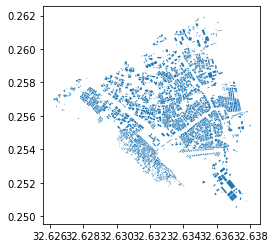

In [47]:
g.plot()

The spatial information (geometries) are stored in the geometry field, which is a pandas series made up of [Shapely](https://shapely.readthedocs.io/en/stable/manual.html) polygons

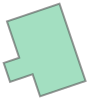

In [52]:
s = g['geometry'].loc[1]
s

In [53]:
print(s)

POLYGON ((32.6352881 0.2607102, 32.6354666 0.2607704, 32.6355552 0.2605077, 32.6354007 0.2604556, 32.6353754 0.2605306, 32.6352986 0.2605047, 32.635277 0.2605689, 32.6353298 0.2605867, 32.6352881 0.2607102))


In [54]:
s.area

5.399010000007857e-08

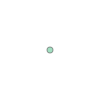

In [55]:
s.centroid

### Raster data (includes images)

Stored as arrays of pixels values that can represent light (i.e. images) or arbitrary values (i.e. land cover classification)  

Examine raster dataset using [GDAL](https://gdal.org/)

In [70]:
!gdalinfo img.tif

Driver: GTiff/GeoTIFF
Files: scene.tif
Size is 39270, 40024
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 36N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 36N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",33,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PARAMETE

We will read raster files using rasterio and store the values in memory as NumPy arrays

In [92]:
import rasterio 

with rasterio.open('img.tif', 'r') as src:
    img = src.read()

img

array([[[ 97, 109, 112, ..., 194, 188, 181],
        [ 94, 104, 106, ..., 195, 190, 185],
        [ 98, 105, 107, ..., 191, 188, 184],
        ...,
        [171, 173, 176, ..., 104, 104, 101],
        [169, 172, 175, ..., 108, 109, 106],
        [176, 179, 181, ..., 112, 114, 111]],

       [[ 91, 105, 110, ..., 144, 138, 131],
        [ 89, 101, 106, ..., 145, 140, 135],
        [ 90,  99, 102, ..., 141, 138, 134],
        ...,
        [158, 160, 162, ..., 136, 135, 133],
        [156, 159, 161, ..., 140, 140, 137],
        [162, 166, 168, ..., 144, 145, 141]],

       [[ 49,  60,  62, ..., 107, 101,  94],
        [ 48,  58,  59, ..., 108, 103,  98],
        [ 50,  56,  57, ..., 104, 101,  97],
        ...,
        [140, 142, 143, ..., 164, 164, 165],
        [138, 141, 143, ..., 167, 166, 166],
        [144, 147, 150, ..., 169, 169, 169]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ..

In [93]:
np.max(img)

255

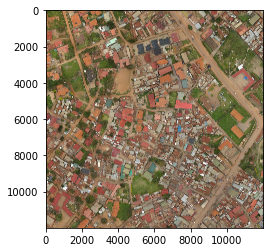

In [94]:
plt.imshow(img.T)

Windowed reading and writing: grab a 1k x 1k pixel image from the very center of this one

In [103]:
with rasterio.open('img.tif') as src:
    witdth = src.width
    hight = src.height
    p = src.profile.copy()

In [109]:
col_off = (src.width / 2) - (1000 / 2)
row_off = (src.height / 2) - (1000 / 2)

In [113]:
pprint(p['transform'])

Affine(0.03533483541714589, 0.0, 458933.27235786483,
       0.0, -0.035334911276512705, 28543.2662871234)


In [111]:
win = Window(col_off=col_off, row_off=row_off, width=1000, height=1000)

In [114]:
x = rasterio.open('img.tif').window_transform(win)

In [115]:
x

Affine(0.03533483541714589, 0.0, 459127.6139526591,
       0.0, -0.035334911276512705, 28348.924275102578)

In [116]:
with rasterio.open('img.tif') as src:
    f = src.read(window=win)
    p = src.profile.copy()
    p['width'] = win.width
    p['height'] = win.height
    p['transform'] = src.window_transform(win)

In [118]:
f.shape

(4, 1000, 1000)

In [119]:
with rasterio.open('sample.tif', 'w', **p) as dst:
    dst.write(f)

In [120]:
!ls

Dockerfile				 buildings.geojson   run
Python_satellite_imagery_workshop.ipynb  docker-compose.yml  sample.tif
README.md				 img		     scene.tif
build					 img.tif
buildings-all-features.geojson		 requirements.txt


## 2) Building training data for Machine Learning  

Coming soon...